In [61]:
##########################
## implement a3 in squin ##
##########################
from bloqade import squin
from bloqade.types import Qubit
from kirin.dialects import ilist
from bloqade.cirq_utils import load_circuit
from bloqade.cirq_utils.emit import emit_circuit
from bloqade.cirq_utils import noise, parallelize, remove_tags, transpile
from cirq.contrib.svg import SVGCircuit,circuit_to_svg
import bloqade.stim
import bloqade.tsim
import numpy as np
from math import pi
from typing import Literal
import cirq


@squin.kernel
def magicstateprep(q: ilist.IList[Qubit, Literal[7]]):
    #squin.h(qubits[ind])
    squin.i(q[2])


def mapping_f(n):
    dicti = {0:1, 1:3, 2:7, 3:6, 4:2, 5:5, 6:4}


'''@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    squin.reset(q[0:6])
    #squin.h(q[6])
    for i in range(6):
        squin.ry(-pi / 2, q[i])
    squin.cz(q[1], q[2])
    squin.cz(q[3], q[4])
    squin.cz(q[5], q[6])
    squin.ry(pi / 2, q[6])
    squin.cz(q[0], q[3])
    squin.cz(q[2], q[5])
    squin.cz(q[4], q[6])
    for i in range(2, 7):
        squin.ry(pi / 2, q[i])
    for i in range(0, 5, 2):
        squin.cz(q[i], q[i + 1])
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[2])
    squin.ry(pi / 2, q[4])

    squin.cx(q[0],q[2])
    squin.cx(q[2],q[0])
    squin.cx(q[0],q[2])

    squin.cx(q[2],q[6])
    squin.cx(q[6],q[2])
    squin.cx(q[2],q[6])

    squin.cx(q[3],q[6])
    squin.cx(q[6],q[3])
    squin.cx(q[3],q[6])

    squin.z(q[3])
    squin.x(q[6])'''

@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    #for i in range(2):
    #    squin.reset(q[i])
    #for i in range(3, 7):
    #    squin.reset(q[i])
    magicstateprep(q)
    # ry(-pi/2) on old 0..5  ->  new [3,1,0,6,4,5]
    for j in (3, 1, 0, 6, 4, 5):
        squin.ry(-pi / 2, q[j])

    # cz(1,2), cz(3,4), cz(5,6) -> cz(1,0), cz(6,4), cz(5,2)
    squin.cz(q[1], q[0])
    squin.cz(q[6], q[4])
    squin.cz(q[5], q[2])

    # ry on old 6 -> new 2
    squin.ry(pi / 2, q[2])

    # cz(0,3), cz(2,5), cz(4,6) -> cz(3,6), cz(0,5), cz(4,2)
    squin.cz(q[3], q[6])
    squin.cz(q[0], q[5])
    squin.cz(q[4], q[2])

    # ry on old 2..6 -> new [0,6,4,5,2]
    for j in (0, 6, 4, 5, 2):
        squin.ry(pi / 2, q[j])

    # cz(0,1), cz(2,3), cz(4,5) -> cz(3,1), cz(0,6), cz(4,5)
    squin.cz(q[3], q[1])
    squin.cz(q[0], q[6])
    squin.cz(q[4], q[5])

    # final single-qubit ry: old 1 -> 1, old 2 -> 0, old 4 -> 4
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[0])
    squin.ry(pi / 2, q[4])
    squin.z(q[3])
    squin.x(q[0])
    squin.x(q[1])
    squin.x(q[3])



@squin.kernel
def main():
    q = squin.qalloc(7)
    injection(q)
    
circ = emit_circuit(main)
circ_load = load_circuit(circ)
circ_stim = bloqade.tsim.Circuit(circ_load)
graph = circ_stim.diagram(type="timeline-svg")


# ---------------------------------------------------------------------------
# Steane [[7,1,3]] Encoding Functions
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode |0⟩^7 → |0⟩_L on the 7-qubit register q (Steane [[7,1,3]])."""
    squin.h(q[0])
    squin.h(q[1])
    squin.h(q[3])
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])


@squin.kernel
def steane_encode_plus_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode 7 qubits as |+⟩_L: first |0⟩_L then transversal H."""
    steane_encode_zero_on(q)
    for i in range(7):
        squin.h(q[i])


# ---------------------------------------------------------------------------
# A3 Circuit: Fault-tolerant Steane syndrome extraction
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit():
    """A3 circuit implementation in squin."""
    q = squin.qalloc(21)
    
    #steane_encode_zero_on(q[0:7])
    injection(q[0:7])
    # Qubits 0-6: logical data
    # Qubits 8-14 + 15-21: ancilla block

    # Prepare ancilla as |+⟩_L for first half (X-stabilizer syndrome)
    steane_encode_plus_on(q[7:14])

    # CNOTs: data → ancilla (X-syndrome extraction)
    for i in range(7):
        squin.cx(q[i], q[i+7])

    # Reset ancilla qubits 8-14
    #for i in range(8, 15):
    #    squin.reset(q[i])
    
    # Prepare ancilla as |0⟩_L for second half (Z-stabilizer syndrome)
    steane_encode_zero_on(q[14:21])

    # CNOTs: ancilla → data (Z-syndrome extraction)
    for i in range(7):
        squin.cx(q[i+14], q[i])

    # Transversal H on ancilla
    for i in range(7):
        squin.h(q[i+14])
    
    # Measure ancilla qubits 7-21 (Syndrome bits)
    for i in range(7, 21):
        squin.measure(q[i])

graph

In [62]:
import copy
from typing import List, Tuple, Optional, Sequence, cast
from collections import deque, defaultdict

import cirq
import numpy as np
from cirq.circuits.qasm_output import QasmUGate

Slot = Tuple[int, int]  # (tuple index, position inside tuple)
Swap = Tuple[Slot, Slot]


def get_equivalent_swaps_greedy(source, target):
    src = expand(source)   # list[list[Optional[int]]], 2 slots each
    tgt = expand(target)

    # Build target positions for each value
    want = defaultdict(deque)  # value -> deque[Slot]
    for i, row in enumerate(tgt):
        for j, val in enumerate(row):
            want[val].append((i, j))

    # Current slot -> value
    pos_to_val = {(i, j): src[i][j] for i in range(len(src)) for j in range(len(src[i]))}

    # Value -> current slots (handle duplicates / None safely)
    have = defaultdict(deque)
    for slot, val in pos_to_val.items():
        have[val].append(slot)

    swaps = []

    # For each slot, ensure the correct value ends up there (according to one valid target assignment)
    for i, row in enumerate(tgt):
        for j, desired in enumerate(row):
            slot = (i, j)
            cur = pos_to_val[slot]
            if cur == desired:
                continue

            # Find some slot that currently holds the desired value
            if not have[desired]:
                # Shouldn't happen if multisets match; fall back safely
                continue
            other = have[desired].popleft()

            # Swap slot <-> other in our bookkeeping
            swaps.append((slot, other))

            v1 = pos_to_val[slot]
            v2 = pos_to_val[other]

            pos_to_val[slot], pos_to_val[other] = v2, v1

            # Update "have" deques: remove/append accordingly
            # (We popped one 'desired' slot already; now update for v1)
            have[v1].append(other)
            # and desired value now sits in `slot`
            have[desired].append(slot)

    return swaps

##We make a distinction between gate and move errors. Gate errors intrinsically depend on the gate type (two qubit gates, local single qubit gates, global single qubit gates)
##Move errors are independent of the gate type, and depend on the qubit spatial layout. For our purposes, an upper bound for the move error is enough per atom move, for a given layout.
def get_qargs_from_moment(moment: cirq.Moment):
    """Returns a list of qubit arguments (qargs) from all operations in a Cirq moment.

    Args:
        moment: A cirq.Moment object.

    Returns:
        A list of tuples, where each tuple contains the qubits acted on by a gate in the moment.
    """

    list_qubs = [op.qubits for op in moment.operations]

    return list_qubs


def flatten_qargs(list_qubs: Sequence[Tuple[cirq.Qid, ...]]) -> List[cirq.Qid]:
    """Flattens a list of lists of qargs
    Args:
        list_qubs: A list of tuples of cirq.Qid objects.
    Returns:
        A flattened list of cirq.Qid objects.
    """
    return [item for tup in list_qubs for item in tup]


def qargs_to_qidxs(qargs: List[Tuple[cirq.LineQubit, ...]]) -> List[Tuple[int, ...]]:
    """
    Transforms list of qargs (tuples of cirq.LineQubit objects) into a list of tuples of integers.
    Each integer corresponds to the index of the qubit in the tuple.
    Args:
        qargs: A list of tuples of cirq.LineQubit objects.
    Returns:
        A list of tuples of integers, where each integer is the index of the qubit in the tuple.
    """
    return [tuple(x.x for x in tup) for tup in qargs]


def get_map_named_to_line_qubits(named_qubits: Sequence[cirq.NamedQubit]) -> dict:
    """
    Maps cirq.NamedQubit('q_i') objects to cirq.LineQubit(i) objects.

    Args:
        named_qubits: A list of cirq.NamedQubit objects.

    Returns:
        A dictionary mapping cirq.NamedQubit to cirq.LineQubit.
    """
    mapping = {}
    for named_qubit in named_qubits:
        # Extract the integer index from the NamedQubit name
        index = int(named_qubit.name.split("_")[1])  # Assumes format 'q_i'
        mapping[named_qubit] = cirq.LineQubit(index)
    return mapping


def numpy_complement(subset: np.ndarray, full: np.ndarray) -> np.ndarray:
    """Returns the elements in `full` that are not in `subset`.
    Args:
        subset: A numpy array of elements to exclude.
        full: A numpy array of elements from which to exclude the subset.
    Returns:
        A numpy array containing elements from `full` that are not in `subset`.
    """
    mask = ~np.isin(full, subset)
    return full[mask]


def intersect_by_structure(
    reference: List[Tuple[int, ...]], target: List[Tuple[int, ...]]
) -> List[Tuple[int, ...]]:
    target_set = set(val for t in target for val in t)
    result = []

    for tup in reference:
        filtered = tuple(val for val in tup if val in target_set)
        result.append(filtered)

    return result


def expand(
    data: Sequence[Tuple[Optional[int], ...]], capacity: int = 2
) -> List[List[Optional[int]]]:
    # Pad each tuple to have exactly `capacity` slots, using None
    return [list(t) + [None] * (capacity - len(t)) for t in data]


def flatten_with_slots(
    data: List[List[Optional[int]]],
) -> List[Tuple[Optional[int], Slot]]:
    # Create list of (value, (tuple_index, slot_index))
    return [(val, (i, j)) for i, row in enumerate(data) for j, val in enumerate(row)]


def regroup(data: List[List[Optional[int]]]) -> List[Tuple[int, ...]]:
    # Turn 2D structure back into list of sorted tuples, ignoring Nones
    return [tuple(sorted([v for v in row if v is not None])) for row in data]


def canonical_form(tuples: List[Tuple[int, ...]]) -> Tuple[Tuple[int, ...], ...]:
    # Normalize by sorting tuples and sorting the list of tuples
    return tuple(sorted(tuple(sorted(t)) for t in tuples))


def apply_swap(data: List[List[Optional[int]]], swap: Swap):
    # Swap values between two slots
    (i1, j1), (i2, j2) = swap
    data[i1][j1], data[i2][j2] = data[i2][j2], data[i1][j1]


def get_equivalent_swaps(
    source: List[Tuple[int, ...]], target: List[Tuple[int, ...]]
) -> List[Swap]:
    src = expand(source)
    tgt = expand(target)

    target_form = canonical_form(regroup(tgt))

    def config_key(state):
        return canonical_form(regroup(state))

    initial_key = config_key(src)
    visited = {initial_key}
    queue = deque([(copy.deepcopy(src), [])])  # (current state, list of swaps made)
    #print("In Equiv Swaps, got to queue")
    print(queue)
    num_queue = 0
    while queue:
        if num_queue % 10 == 0:
            pass
            #print("Round i",num_queue)
            #print("Queue Length",len(queue))
        #print("Queue is",queue)
        state, swaps = queue.popleft()

        if config_key(state) == target_form:
            return swaps

        flat = flatten_with_slots(state)

        for i in range(len(flat)):
            for j in range(i + 1, len(flat)):
                (_, slot_i), (_, slot_j) = flat[i], flat[j]
                apply_swap(state, (slot_i, slot_j))
                key = config_key(state)
                
                if key not in visited:
                    visited.add(key)
                    queue.append((copy.deepcopy(state), swaps + [(slot_i, slot_j)]))

                apply_swap(state, (slot_i, slot_j))  # Undo swap
        num_queue += 1

    return []  # Should not happen if input is valid


def greedy_unique_packing(data: List[int]) -> List[List[int]]:

    remaining = deque(data)
    result = []

    while remaining:
        used = set()
        group = []
        i = 0
        length = len(remaining)

        while i < length:
            item = remaining.popleft()
            if item not in used:
                group.append(item)
                used.add(item)
            else:
                # Push it to the end for future groups
                remaining.append(item)
            i += 1

        result.append(group)

    return result


def get_swap_move_qidxs(
    swaps: List[Swap], init_qidxs: Sequence[Tuple[Optional[int], ...]]
) -> List[List[int]]:
    # Convert tuples to mutable lists
    swap_init_qidxs = expand(init_qidxs)

    moved_qidxs = []

    for (i1, j1), (i2, j2) in swaps:
        first_idx = swap_init_qidxs[i1][j1]
        sec_idx = swap_init_qidxs[i2][j2]

        if first_idx is not None:
            moved_qidxs.append(first_idx)
        if sec_idx is not None:
            moved_qidxs.append(sec_idx)

        # Perform the swap
        swap_init_qidxs[i1][j1], swap_init_qidxs[i2][j2] = sec_idx, first_idx

    return greedy_unique_packing(moved_qidxs)


def pad_with_empty_tups(
    target: List[Tuple[int, ...]], nqubs: int
) -> List[Tuple[int, ...]]:

    while len(target) < nqubs:
        target.append(())

    return target


def add_noise_to_swaps(
    swaps: List[Swap],
    init_qidxs: List[Tuple[int, ...]],
    move_noise: cirq.AsymmetricDepolarizingChannel,
    sitter_noise: cirq.AsymmetricDepolarizingChannel,
    nqubs: int,
):
    """
    Applies move noise to qubits that need to be swapped to reach a given configuration. This can be seen as the noise added to "pair-up"
    or separate qubits to reach a target configuration before the application of gates
    Args:
    swaps, array of swaps
    init_qidxs, qargs that reach the target configuration once the swaps are applied on it
    move_noise, Pauli noise channel for moves
    sitter_noise, Pauli channel for sitter noise
    nqubs, the circuit width
    """
    built_circuit = cirq.Circuit()
    nqubs_idxs = np.arange(nqubs)

    batches_move_qidxs = get_swap_move_qidxs(swaps, init_qidxs)

    for batch in batches_move_qidxs:
        built_moment = cirq.Moment()
        non_mov_qidxs = numpy_complement(np.array(batch), nqubs_idxs)

        for i in range(len(batch)):
            built_moment += move_noise(cirq.LineQubit(batch[i]))
        for j in range(len(non_mov_qidxs)):
            built_moment += sitter_noise(cirq.LineQubit(non_mov_qidxs[j]))

        built_circuit.append(built_moment)

    # built_circuit.append(built_moment)

    return built_circuit


#############################################


def get_gate_error_channel(
    moment: cirq.Moment,
    sq_loc_rates: np.ndarray,
    sq_glob_rates: np.ndarray,
    two_qubit_pauli: cirq.Gate,
    unp_cz_rates: np.ndarray,
    nqubs: int,
):
    """Applies gate errors to the circuit

    Args:
        moment: A cirq.Moment object.
        sq_loc_rates: single local qubit rotation Pauli noise channel parameters (px, py, pz)
        sq_glob_rates: single global qubit rotation Pauli noise channel parameters (px,py,pz)
        two_qubit_pauli: correlated two-qubit noise channel (ctrl_px, ctrl_py,ctrl_pz,tar_px,tar_py,tar_pz)
        unp_cz_rates: Pauli noise channel parameters for qubits in the gate zone and outside blockade radius
        nqubs: total number of qubits
    Returns:
        A new cirq.Moment object with the gate errors applied.
    """
    # Check for the moment (layer) layout: global single qubit gates, or mixture of single qubit gates and two qubit gates

    gates_in_layer = extract_u3_and_cz_qargs(moment)
    new_moments = cirq.Circuit()

    if gates_in_layer["cz"] == []:

        if gates_in_layer["u3"] == []:
            pass
            #print(
                #"Warning: Assumed Only single qubit gates in the layer, but there are no single qubit gates"
            #)

        if all(
            np.all(np.isclose(element, gates_in_layer["angles"][0]))
            for element in gates_in_layer["angles"]
        ) and nqubs == len(gates_in_layer["u3"]):
            pauli_channel = cirq.AsymmetricDepolarizingChannel(
                p_x=sq_glob_rates[0], p_y=sq_glob_rates[1], p_z=sq_glob_rates[2]
            )

            for qub in gates_in_layer["u3"]:

                # new_moment = new_moment +pauli_channel(qub[0])
                new_moments.append(pauli_channel(qub[0]))
        else:
            pauli_channel = cirq.AsymmetricDepolarizingChannel(
                p_x=sq_loc_rates[0], p_y=sq_loc_rates[1], p_z=sq_loc_rates[2]
            )
            for qub in gates_in_layer["u3"]:

                # new_moment = new_moment + pauli_channel(qub[0])
                new_moments.append(pauli_channel(qub[0]))

    else:
        # there is at least one CZ gate...
        loc_rot_pauli_channel = cirq.AsymmetricDepolarizingChannel(
            p_x=sq_loc_rates[0], p_y=sq_loc_rates[1], p_z=sq_loc_rates[2]
        )
        unp_cz_pauli_channel = cirq.AsymmetricDepolarizingChannel(
            p_x=unp_cz_rates[0], p_y=unp_cz_rates[1], p_z=unp_cz_rates[2]
        )

        # apply correlated noise to paired qubits
        for qub in gates_in_layer["cz"]:
            new_moments.append(two_qubit_pauli.on(qub[0], qub[1]))

        for qub in gates_in_layer["u3"]:
            new_moments.append(
                unp_cz_pauli_channel(qub[0])
            )  ###qubits in the gate zone get unpaired_cz error
            new_moments.append(loc_rot_pauli_channel(qub[0]))

    return new_moments


def add_move_and_sitter_channels(
    ref_qargs: Sequence[Tuple[cirq.Qid, ...]] | None,
    tar_qargs: Sequence[Tuple[cirq.Qid, ...]],
    built_moment: cirq.Moment,
    qub_reg: Sequence[cirq.Qid],
    sitter_pauli_channel: cirq.Gate,
    move_pauli_channel: cirq.Gate,
):
    """
    Adds move and sitter noise channels according to the following rule: all the qargs in ref_moment that
    are absent in tar_moment get a move error and the rest of qubits in the qub_reg get a sitter error. It also returns a boolean variable
    that determines whether move noise was added

    Args:
        ref_qargs: reference qargs
        tar_qargs: moment to make the comparison with
        built_moment: the moment to which we append the noise channels
        qub_reg: the qubit register
        sitter_pauli channel: the parameterized sitter channel
        move_pauli_channel: the parameterized move_pauli channel
    """

    # Faltten ref_qargs and ref_qargs for purposes of identifying how to apply noise:
    flat_tar_qargs = flatten_qargs(tar_qargs)

    if ref_qargs is None:  # we are adding noise to the beginning of circuit...

        flat_ref_qargs = flatten_qargs(tar_qargs)

        bool_list = [k not in flat_tar_qargs for k in flat_ref_qargs]

    else:
        flat_ref_qargs = flatten_qargs(ref_qargs)

        bool_list = [k in flat_tar_qargs for k in flat_ref_qargs]

    rem_qubs = []

    for i in range(len(flat_ref_qargs)):
        if not bool_list[i]:
            rem_qubs.append(flat_ref_qargs[i])
            built_moment += move_pauli_channel(flat_ref_qargs[i])

    if len(rem_qubs) >= 1:

        for k in range(len(qub_reg)):
            if qub_reg[k] not in rem_qubs:
                built_moment += sitter_pauli_channel(qub_reg[k])

        return built_moment, True
    else:
        return built_moment, False


def get_move_error_channel_two_zoned(
    curr_moment: cirq.Moment,
    prev_moment: cirq.Moment | None,
    move_rates: np.ndarray,
    sitter_rates: np.ndarray,
    nqubs: int,
):
    """Applies move noise channels to a cirq moment (curr_moment), depending on the qargs of another one (prev_moment)
    returns a circuit that contains the noisy moments

    Args:
        curr_moment: A cirq.Moment object.
        prev_moment: A cirq.Moment object
        move_rates: Pauli noise channel parameters for atom moves (px,py,pz)
        sitter_rates: probailities of sitter noise (px,py,pz)
        nqubs: total number of qubits (width of the circuit)
    Returns:
        A circuit with atom move channels appended
    """

    curr_qargs = get_qargs_from_moment(curr_moment)

    move_pauli_channel = cirq.AsymmetricDepolarizingChannel(
        p_x=move_rates[0], p_y=move_rates[1], p_z=move_rates[2]
    )
    sitter_pauli_channel = cirq.AsymmetricDepolarizingChannel(
        p_x=sitter_rates[0], p_y=sitter_rates[1], p_z=sitter_rates[2]
    )
    qub_reg = [cirq.LineQubit(i) for i in range(nqubs)]

    if prev_moment is None:
        ###Initial layer of circuit, all qubits in the first layer get move error, rest get sitter
        new_moment = cirq.Moment()
        dumb_circ = cirq.Circuit()
        new_moment, _ = add_move_and_sitter_channels(
            prev_moment,
            curr_qargs,
            new_moment,
            qub_reg,
            sitter_pauli_channel,
            move_pauli_channel,
        )
        dumb_circ.append(new_moment)

    else:
        #print("Entered Prev Moment")
        prev_qargs = get_qargs_from_moment(prev_moment)
        # We follow this convention: 1) all qargs in previous moment that need to be removed from gate zone
        # get move error, the rest get sitter error. 2) after this, all qargs that need to be brought to
        # gate zone get move error, the rest get sitter error.
        new_moment = cirq.Moment()
        dumb_circ = cirq.Circuit()
        new_moment, first_move_added = add_move_and_sitter_channels(
            prev_qargs,
            curr_qargs,
            new_moment,
            qub_reg,
            sitter_pauli_channel,
            move_pauli_channel,
        )
        dumb_circ.append(new_moment)
        #print("DumbCirc pt. 1 Done")
        new_moment = cirq.Moment()
        new_moment, second_move_added = add_move_and_sitter_channels(
            curr_qargs,
            prev_qargs,
            new_moment,
            qub_reg,
            sitter_pauli_channel,
            move_pauli_channel,
        )
        dumb_circ.append(new_moment)
        #print("Dumb cirq pt. 2 done")
        # Once the noise channels to have the target qargs in the gate zone are added, we include an additional move error
        # to reconfigure

        # Find the initial and final qarg configuration in the previous and current moments...
        prev_qidxs = qargs_to_qidxs(prev_qargs)
        curr_qidxs = qargs_to_qidxs(curr_qargs)
        #print("Before Intsc")
        intsc_rev = intersect_by_structure(prev_qidxs, curr_qidxs)
        intsc_fow = intersect_by_structure(curr_qidxs, prev_qidxs)
        #print("Before Swaps")
        # get swaps that render previous configuration to current...
        m = max(len(intsc_rev), len(intsc_fow))  # or gate_zone_capacity if you have it
        swaps = get_equivalent_swaps_greedy(
            pad_with_empty_tups(intsc_rev, nqubs),
            pad_with_empty_tups(intsc_fow, nqubs),
        )
        #swaps = get_equivalent_swaps(
        #    pad_with_empty_tups(intsc_rev, nqubs), pad_with_empty_tups(intsc_fow, nqubs)
        #)
        #print("Before Noise done")
        # apply noise channels...

        swap_noise_circ = add_noise_to_swaps(
            swaps, intsc_rev, move_pauli_channel, sitter_pauli_channel, nqubs
        )
        dumb_circ.append(swap_noise_circ)

    return dumb_circ


def extract_u3_and_cz_qargs(moment: cirq.Moment):
    """
    Extracts the qubit arguments (qargs) for u3 and CZ gates from a Cirq moment,
    and the angle parameters of the u3 gates.

    Args:
        moment: A cirq.Moment object containing only u3 and CZ gates.

    Returns:
        A dictionary with keys 'u3', 'cz', and 'angles', where:
        - 'u3' maps to a list of qargs (tuples of qubits) for u3 OR PhXZ gates.
        - 'cz' maps to a list of qargs (tuples of qubits) for CZ gates.
        - 'angles' maps to a list of angle parameters (tuples) for the u3 gates.
    """
    result = {"u3": [], "cz": [], "angles": []}

    for op in moment.operations:

        if isinstance(op.gate, QasmUGate):  # u3 gate in Cirq
            result["u3"].append(op.qubits)
            # Extract angle parameters (x_exponent, z_exponent, axis_phase_exponent)
            gate = cast(QasmUGate, op.gate)
            angles = (gate.theta, gate.phi, gate.lmda)
            result["angles"].append(angles)
        elif isinstance(op.gate, cirq.PhasedXZGate):  # CZ gate in Cirq
            result["u3"].append(op.qubits)
            # Extract angle parameters (x_exponent, z_exponent, axis_phase_exponent)
            gate = cast(cirq.PhasedXZGate, op.gate)
            angles = (gate.x_exponent, gate.z_exponent, gate.axis_phase_exponent)

            result["angles"].append(angles)
        elif isinstance(op.gate, cirq.CZPowGate):  # CZ gate in Cirq

            result["cz"].append(op.qubits)

    return result

In [63]:
import copy
from typing import List, Tuple, Optional, Sequence, cast, Iterable
from collections import deque
from dataclasses import dataclass

@dataclass(frozen=True)
class GeminiTwoZoneNoiseModel(noise.model.GeminiNoiseModelABC):
    def noisy_moments(
        self, moments: Iterable[cirq.Moment], system_qubits: Sequence[cirq.Qid]
    ) -> Sequence[cirq.OP_TREE]:
        """Adds possibly stateful noise to a series of moments.

        Args:
            moments: The moments to add noise to.
            system_qubits: A list of all qubits in the system.

        Returns:
            A sequence of OP_TREEEs, with the k'th tree corresponding to the
            noisy operations for the k'th moment.
        """

        if self.check_input_circuit:
            self.validate_moments(moments)

        moments = list(moments)

        if len(moments) == 0:
            return []

        nqubs = len(system_qubits)
        noisy_moment_list = []
        #print("Entered Noisy Moments Lets Go")
        prev_moment: cirq.Moment | None = None

        # TODO: clean up error getters so they return a list moments rather than circuits
        #print("Total Moments")
        for i in range(len(moments)):
            #print("Current moment",i)
            '''print("Before the big thing")
            print("Moment",moments[i])
            print("Prev Moment",prev_moment)
            print("Mover Pauli",np.array(self.mover_pauli_rates))
            print("Sitter Pauli",np.array(self.sitter_pauli_rates))
            print("NQubits",nqubs)'''
            '''print("The big thing:", noise._two_zone_utils.get_move_error_channel_two_zoned(
                        moments[i],
                        prev_moment,
                        np.array(self.mover_pauli_rates),
                        np.array(self.sitter_pauli_rates),
                        nqubs,
                    ).moments)'''
            noisy_moment_list.extend(
                [
                    moment
                    for moment in get_move_error_channel_two_zoned(
                        moments[i],
                        prev_moment,
                        np.array(self.mover_pauli_rates),
                        np.array(self.sitter_pauli_rates),
                        nqubs,
                    ).moments
                    if len(moment) > 0
                ]
            )
            #print("Ended First Block")
            noisy_moment_list.append(moments[i])

            noisy_moment_list.extend(
                [
                    moment
                    for moment in noise._two_zone_utils.get_gate_error_channel(
                        moments[i],
                        np.array(self.local_pauli_rates),
                        np.array(self.global_pauli_rates),
                        self.two_qubit_pauli,
                        np.array(self.cz_unpaired_pauli_rates),
                        nqubs,
                    ).moments
                    if len(moment) > 0
                ]
            )

            prev_moment = moments[i]

        return noisy_moment_list

In [64]:
import cirq


def transform_circuit(
    circuit: cirq.Circuit,
    to_native_gateset: bool = True,
    model: cirq.NoiseModel | None = None,
    parallelize_circuit: bool = False,
) -> cirq.Circuit:
    """Transform an input circuit into one with the native gateset with noise operations added.

    Noise operations will be added to all qubits in circuit.all_qubits(), regardless of whether the output of the
    circuit optimizers contain all the qubits.

    Args:
        circuit (cirq.Circuit): The input circuit.

    Keyword Arguments:
        to_native_gateset (bool): Whether or not to convert the input circuit to one using the native set of gates (`cirq.CZTargetGateset`)
            only. Defaults to `True`. Note, that if you use an input circuit that has gates different from this gateset and don't convert it,
            may lead to incorrect results and errors.
        model (cirq.NoiseModel): The cirq noise model to apply to the circuit. Usually, you want to use one of the ones supplied in this submodule,
            such as `GeminiOneZoneNoiseModel`.
        parallelize_circuit (bool): Whether or not to parallelize the circuit as much as possible after it's been converted to the native gateset.
            Defaults to `False`.

    Returns:
        cirq.Circuit:
            The resulting noisy circuit.
    """
    if model is None:
        model = noise.GeminiOneZoneNoiseModel(parallelize_circuit=parallelize_circuit)

    # only parallelize here if we aren't parallelizing inside a one-zone model
    parallelize_circuit_here = parallelize_circuit and not isinstance(
        model, noise.GeminiOneZoneNoiseModel
    )
    #print("Got to System Qubits")
    system_qubits = sorted(circuit.all_qubits())
    # Transform to CZ + PhasedXZ gateset.
    if to_native_gateset and not parallelize_circuit_here:
        native_circuit = transpile(circuit)
    elif parallelize_circuit_here:
        native_circuit = parallelize(circuit)
    else:
        native_circuit = circuit

    #print("Got Native Qubits")
    # Add noise
    noisy_circuit = cirq.Circuit()
    #print("Got to Noisy Moments")
    for op_tree in model.noisy_moments(native_circuit, system_qubits):
        # Keep moments aligned
    #    print("OpTree",op_tree)
        noisy_circuit += cirq.Circuit(op_tree)

    return noisy_circuit

In [65]:

# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------

loops = 1
shots_per_loop = 1000
all_samples = []

# Noise channel
noise_model = GeminiTwoZoneNoiseModel(scaling_factor=1)

for i in range(loops):
    # Generate circuit
    cirq_enc = emit_circuit(a3_circuit)
    # Parallelize a circuit
    parallel_circuit = parallelize(cirq_enc)
    # Remove internal tags (for cleaner visualization)
    parallel_circuit = remove_tags(parallel_circuit)
    #svg_text = SVGCircuit(parallel_circuit)._repr_svg_()

    #with open("circuit.svg", "w", encoding="utf-8") as f:
    #    f.write(svg_text)
    #print("I am before the transform")
    # Apply noise to this circuit
    noisy_cirq_enc = transform_circuit(cirq_enc, model=noise_model)
    #print("I am at this stage")
    # Convert to stim circuit and sample
    squin_enc = load_circuit(noisy_cirq_enc)
    stim_enc = bloqade.tsim.Circuit(squin_enc)
    sampler = stim_enc.compile_sampler()
    #print("I am at that stage")
    # Sample this noisy circuit
    samples = sampler.sample(shots=shots_per_loop)
    all_samples.extend(samples)

samples_enc = np.array(all_samples)

# Show diagram from last circuit

#print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
#print(f"Total samples collected: {len(samples_enc)} ({loops} loops × {shots_per_loop} shots)")
#print("Sample shape:", samples_enc.shape)
#print("First 5 shots:\n", samples_enc[:5])
#print(f"Error rate: {np.count_nonzero(samples_enc)/len(samples_enc):.4f}")


MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)
Total samples collected: 1000 (1 loops × 1000 shots)
Sample shape: (1000, 14)
First 5 shots:
 [[False False False False False False False False  True False False False
   True False]
 [ True  True  True False  True  True False  True False  True False False
  False  True]
 [ True False  True False  True  True False False False False False  True
   True  True]
 [False  True False  True False  True False False  True False False  True
  False  True]
 [ True  True  True False False False False False False  True  True False
  False  True]]
Error rate: 7.0060


In [66]:

synd_dict = {1:[1,3,5,7],2:[4,5,6,7],3:[2,3,6,7]}

In [67]:
def to_parity(li):
    li_new = [-2*el+1 for el in li]
    return li_new

li = [False, True, False]

In [68]:
def find_syndrome(li, idx):
    li = to_parity(li)
    mult = 1
    for ind in idx:
        mult *= li[ind-1]
    return True if mult == 1 else False


In [69]:
def findZSyndrome(sample,idx):
    sample_z = sample[0:7]
    return find_syndrome(sample_z,idx)

def findXSyndrome(sample,idx):
    sample_x = sample[7:14]
    return find_syndrome(sample_x,idx)

In [70]:
def compute_syndromes(sample,ind_dict):
    x_synds = []
    z_synds = []
    for key in list(ind_dict.keys()):
        idx = ind_dict[key]
        x_synds.append(findXSyndrome(sample,idx))
        z_synds.append(findZSyndrome(sample,idx))
    return x_synds,z_synds

In [71]:
def find_good_rate(samples,ind_dict):
    tot_samples = len(samples)
    good_samples = 0
    for j,sample in enumerate(samples):
        synd = compute_syndromes(sample,ind_dict)
        print(synd)
        will_add = 1 if np.count_nonzero(synd) == 6 else 0
        good_samples+=will_add
    return (good_samples)/len(samples)

In [72]:
print(find_good_rate(samples_enc,synd_dict))

([True, False, True], [True, True, True])
([False, False, True], [False, True, False])
([True, False, True], [False, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([False, False, True], [True, False, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([True, True, False], [True, True, True])
([False, True, True], [True, False, True])
([False, True, True], [False, True, True])
([False, True, True], [True, True, True])
([False, True, True], [True, True, False])
([True, True, True], [False, True, False])
([False, True, False], [False, True, False])
([True, True, True], [True, True, True])
([True, False, False], [False, False, True])
([False, True, False], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [False, False, True])
([True, True, True], [True, False, True])
([True, True, True], [False, True, False])
([False, True, True], 

([False, False, True], [True, True, True])
([True, False, True], [False, True, True])
([True, True, True], [True, True, True])
([True, False, True], [False, True, True])
([True, True, True], [False, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, False])
([True, False, True], [True, True, True])
([True, True, True], [True, True, True])
([False, True, False], [True, True, True])
([True, True, True], [True, True, True])
([True, False, True], [True, False, True])
([False, False, True], [True, True, True])
([True, False, False], [True, True, False])
([True, True, False], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [False, False, False])
([True, True, True], [True, True, True])
([False, True, False], [True, True, True])
([False, False, False], [True, True, True])
([True, True, True], [True, True, True])
([False, True, True], [True, T

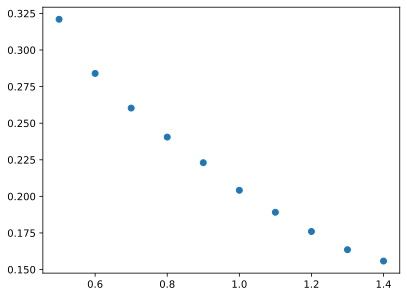

In [73]:

import matplotlib.pyplot as plt
# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------

loops = 1
shots_per_loop = 1000
all_samples = []
fidelities = []

coeffs = np.arange(0.5,1.5,0.1)
#coeffs = [1.0]

for coeff in coeffs:
    # Noise channel
    noise_model = GeminiTwoZoneNoiseModel(scaling_factor=coeff)

    for i in range(loops):
        # Generate circuit
        cirq_enc = emit_circuit(a3_circuit)
        
        # Apply noise to this circuit
        noisy_cirq_enc = noise.transform_circuit(cirq_enc, model=noise_model)
        
        # Convert to stim circuit and sample
        squin_enc = load_circuit(noisy_cirq_enc)
        stim_enc = bloqade.stim.Circuit(squin_enc)
        sampler = stim_enc.compile_sampler()
        
        # Sample this noisy circuit
        samples = sampler.sample(shots=shots_per_loop)
        all_samples.extend(samples)

    samples_enc = np.array(all_samples)
    fidelities.append(find_good_rate(samples_enc,synd_dict))

plt.scatter(coeffs,fidelities)
plt.show()
    



In [74]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Model: y = A * p^(-n)
def scaling(p, A, n):
    return A * np.power(p, -n)

In [75]:
n0 = 1.0
A0 = fidelities[0] * (coeffs[0] ** n0)  # rough guess
p0 = (A0, n0)

In [76]:
popt, pcov = curve_fit(scaling, coeffs, fidelities, p0=p0, maxfev=10000)
A_fit, n_fit = popt
A_err, n_err = np.sqrt(np.diag(pcov))

print(f"A = {A_fit:.6g} ± {A_err:.2g}")
print(f"n = {n_fit:.6g} ± {n_err:.2g}")

A = 0.201755 ± 0.0015
n = 0.686238 ± 0.018


In [77]:
funcs = scaling(coeffs,A_fit,n_fit)

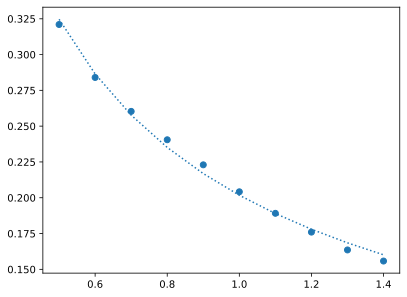

In [78]:
plt.scatter(coeffs,fidelities)
plt.plot(coeffs,funcs,ls = ":")
plt.show()